In [1]:
## Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, WeekdayLocator, MonthLocator, DayLocator, DateLocator, DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import datetime, calendar
%matplotlib inline


## Import data frome pickle generated from hotline_daily.py
data = pd.read_pickle('/home/keuch/gits/keuch/code_box/pyt/spreadsheetparsing/entwuerfe/pickle_2304.pkl')

In [2]:
def rearrange(df):
    index_filter=df.loc[['tix']] ## select all hours-index rows
    
    hourse=list(range(0,25))  ## these is from 0 to 24 (25 entries!) and maps the hour indices
    mh=index_filter[hourse]  ## columns with half- and hour steps were named 0-24
    oldcols=mh.columns.values.tolist() ## list of the names of the hourse
    newcols=mh.loc['tix'].drop_duplicates().loc['tix'].values.tolist() ## one row of the hour indices provides the new column names
    cols=dict(zip(oldcols,newcols)) ## old column names get mapped to new columns names

    mhnew=df.rename(columns=cols).drop('tix') ## new dataframe has the old 'tix' entries as column names; 'tix' rows are dropped since not needed any more
    mhnew=mhnew.reset_index().set_index(['xlday']).rename(columns={'index':'status'}) ## new index will be the excel date numbers, old index is moved to a column named 'status'
    
    return mhnew, newcols

In [3]:
def timerange(*,df, years, months=range(1,13), weeks=range(1,53), weekdays=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']):
    resultat=df.loc[(df['year'].isin(years)) & (df['month'].isin(months)) & (df['week'].isin(weeks)) & (df['weekday'].isin(weekdays))]
    return resultat

# end of function definitions

In [4]:
ndata,hcols=rearrange(data) ## rearranged dataframe with hour_indices as colums and list of hour_index-columns for future use
#ndata.head()

### time range filter:
Arguments must be passed as a list or as a range. Example:

**timerange(df=ndata,years=[2016,2017],months=[3],weeks=[6],weekdays=['Sun','Sun'])**

Note the double entry for a single weekday!
Leaving parameters empty gives default values (=all). Months and Weeks may be mutually exclusive and raise exceptions

In [5]:
plotframe = timerange(df=ndata,years=[2017],weeks=[4])

In [6]:
pf = plotframe.drop(hcols,axis=1)  ## at this place, we dont need the hourly figures, only day sums

#pf.loc[:, pf.loc[['status']] == 'angekommen']  THIS DOES NOT WORK. The Colon ist wrong and stuff
#pf.loc[pf['status'] == 'angekommen'].summa


In [47]:
def fplot(zeitspanne,frame,titel):
    fig = plt.figure()
    ax = fig.add_subplot(111)
   
    x_achse_an=pf.loc[frame['status'] == 'angekommen'].date.values
    y_achse_an=pf.loc[frame['status'] == 'angekommen'].summa.values
    x_achse_vb=pf.loc[frame['status'] == 'verbunden'].date.values
    y_achse_vb=pf.loc[frame['status'] == 'verbunden'].summa.values
    x_achse_vl=pf.loc[frame['status'] == 'verloren'].date.values
    y_achse_vl=pf.loc[frame['status'] == 'verloren'].summa.values
    x_achse_sla=pf.loc[frame['status'] == 'servicelevel'].date.values
    y_achse_sla=pf.loc[frame['status'] == 'servicelevel'].summa.values
    
    if len(x_achse_an) < 8:
        plt.rcParams["figure.figsize"] = [6,4]


    if zeitspanne == 'jahr':
        xtit='gesamtes Jahr'
    elif zeitspanne == 'monat':
        start=x_achse_an.min().strftime('%d.%m.%Y')
        ende=x_achse_an.max().strftime('%d.%m.%Y')
        ax.set_title('Anrufe '+start+' - '+ende)
        xtick_locator_mj = DayLocator(bymonthday=range(3,32,4))
        xtick_locator_mn = DayLocator(bymonthday=range(1,32,4))
        xtick_formatter = DateFormatter('%a,%d.%m.')
        ax.xaxis.set_major_locator(xtick_locator_mj)
        ax.xaxis.set_minor_locator(xtick_locator_mn)
        ax.xaxis.set_major_formatter(xtick_formatter)
        ax.xaxis.set_minor_formatter(xtick_formatter)
        ax.xaxis.set_tick_params(which='major', pad=1, length=20, width=1.5, labelsize=6,zorder=20)
        ax.xaxis.set_tick_params(which='minor', pad=1, length=5, width=1.5, labelsize=6,zorder=2)
    elif zeitspanne == 'woche':
        kw=x_achse_an.min().strftime('%W')
        ax.set_title('Anrufe KW '+kw)
        ax.title.set_position([.5, 1.05])
        xtick_locator_mn = WeekdayLocator(byweekday=[TU,WE,TH,FR,SA,SU])
        xtick_formatter_mn = DateFormatter('%d.%m.')
        xtick_locator_mj = WeekdayLocator(byweekday=MO)
        xtick_formatter_mj = DateFormatter('%a,%d.%m.')
        ax.xaxis.set_major_locator(xtick_locator_mj)
        ax.xaxis.set_major_formatter(xtick_formatter_mj)
        ax.xaxis.set_minor_locator(xtick_locator_mn)
        ax.xaxis.set_minor_formatter(xtick_formatter_mn)
        ax.xaxis.set_tick_params(which='both', pad=1, length=5, width=1.5, labelsize=6,zorder=20)
        # Y-Axis: major ticks every 50, minor ticks every 10  
        ax.set_axisbelow(True)
        ax.yaxis.grid(True)
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax.yaxis.grid(True, which='minor', color='#E8E6BF', linestyle='--', alpha=0.5, zorder=0)
        ax.yaxis.grid(True, which='major', color='#6DC3EC', linestyle='-', zorder=3)
    
    ax.set_zorder(5) 
    ax.margins(0.01)
    ax.set_ylabel('Anrufe')
    an_bar=ax.bar(x_achse_an,y_achse_an,width=0.8, alpha=1, color='#ECB2FF', label='angekommen', align='center',zorder=5)
    vb_bar=ax.bar(x_achse_vb,y_achse_vb,width=0.6, alpha=1, color='#005BC2', label='verbunden', align='center',zorder=5)
    vl_bar=ax.bar(x_achse_vl,y_achse_vl,width=0.4, alpha=1, color='#000000', label='verloren', align='center',zorder=5)
    
    for bar in vb_bar:
        coords=[bar.get_x(),bar.get_height()]
        tde=int(coords[1])
        tx=ax.text(coords[0]+0.3,coords[1]+1.5,s=str(tde),size=9,color='#005BC2',weight='bold',zorder=100,ha='center')
        #tx=ax.text(coords[0]+0.3,coords[1]+1.5,s=str(tde),size=9,color='#13B3F5',weight='bold',zorder=100,ha='center')
        #tx.set_bbox(dict(color='#ffffff', alpha=0.5,capstyle='butt',zorder=0))

        
    ax2 = ax.twinx()
    sla_color="#FF2224"
    ax2.set_zorder(5) 
    ax2.set_axisbelow(True)
    slamark=ax2.plot(x_achse_sla,y_achse_sla*100,c=sla_color,marker='.', ls='None')
    ax2.axhline(y=80, color=sla_color, alpha=0.5, linestyle=':', label="80% SLA",zorder=0) # show the desired SLA
    ax2.set_ylabel('% SLA',color=sla_color)
    lowest_sla=y_achse_sla.min()*100
    if lowest_sla > 50:
        ax2.set_ylim(bottom=50, top=100)
    else:
        ax2.set_ylim(bottom=lowest_sla, top=100)
    for coords in slamark[0].get_xydata():
        tde=round(coords[1],1)
        tx=ax2.text(coords[0],ax2.get_ylim()[1]+1.5,s=str(tde)+'%',size=7,color=sla_color,weight='bold',ha='center',zorder=10)
        #tx.set_bbox(dict(edgecolor='#ffffff', alpha=0.5,capstyle='butt',zorder=0))
        ax2.spines['right'].set_color(sla_color)
        ax2.spines['top'].set_color(sla_color)
        
        ax2.yaxis.label.set_color(sla_color)
        ax2.tick_params(axis='y', colors=sla_color)
    
    fig.tight_layout()
    ax.legend()

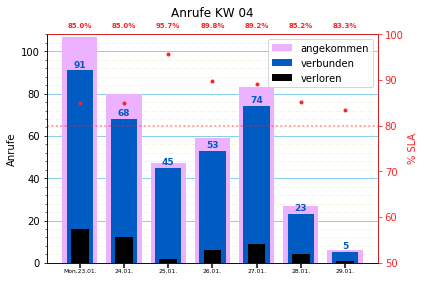

In [48]:
## Woche oder Monat angeben
for i in range (4,5):
    plotframe = timerange(df=ndata,years=[2017],weeks=[i])
    pf = plotframe.drop(hcols,axis=1)
    fplot('woche',pf,'arbeitstitel')
